In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-data-set/diabetes.csv


In [2]:
!pip install llvmlite==0.37.0 --user
!pip install pycaret --user
!pip install scikit-learn==0.23.2 --user
!pip install numpy==1.20 --user

# About Dataset

## Context

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

## Content

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

+ Pregnancies: Number of times pregnant
+ Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
+ BloodPressure: Diastolic blood pressure (mm Hg)
+ SkinThickness: Triceps skin fold thickness (mm)
+ Insulin: 2-Hour serum insulin (mu U/ml)
+ BMI: Body mass index (weight in kg/(height in m)^2)
+ DiabetesPedigreeFunction: Diabetes pedigree function
+ Age: Age (years)
+ Outcome: Class variable (0 or 1)

## Past Usage:
```
1. Smith,~J.~W., Everhart,~J.~E., Dickson,~W.~C., Knowler,~W.~C., \&
   Johannes,~R.~S. (1988). Using the ADAP learning algorithm to forecast
   the onset of diabetes mellitus.  In {\it Proceedings of the Symposium
   on Computer Applications and Medical Care} (pp. 261--265).  IEEE
   Computer Society Press.

   The diagnostic, binary-valued variable investigated is whether the
   patient shows signs of diabetes according to World Health Organization
   criteria (i.e., if the 2 hour post-load plasma glucose was at least 
   200 mg/dl at any survey  examination or if found during routine medical
   care).   The population lives near Phoenix, Arizona, USA.

   Results: Their ADAP algorithm makes a real-valued prediction between
   0 and 1.  This was transformed into a binary decision using a cutoff of 
   0.448.  Using 576 training instances, the sensitivity and specificity
   of their algorithm was 76% on the remaining 192 instances.
```
## Relevant Information:
```
  Several constraints were placed on the selection of these instances from
  a larger database.  In particular, all patients here are females at
  least 21 years old of Pima Indian heritage.  ADAP is an adaptive learning
  routine that generates and executes digital analogs of perceptron-like
  devices.  It is a unique algorithm; see the paper for details.
```

# Load Libraries

In [67]:
# import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                        precision_score, recall_score, f1_score, 
                        plot_roc_curve, plot_precision_recall_curve,
                        accuracy_score)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from pycaret.classification import *

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

%matplotlib inline
plt.style.use("dark_background")

----
## Data Upload 

In [5]:
df = pd.read_csv("../input/diabetes-data-set/diabetes.csv", sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


The first restriction that we must keep in mind is that the dataset is not so large as to discard samples so easily, so in cases of empties or unusual data we must keep in mind them and so search alternative preprocessing for this dataset without the need to delete them.

----
----
## Data visualization
---
### Searching for missing data holdings:


In [6]:
df.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

It is evident that there are no empty data

----
### Data exploration:

<AxesSubplot:xlabel='Age', ylabel='Count'>

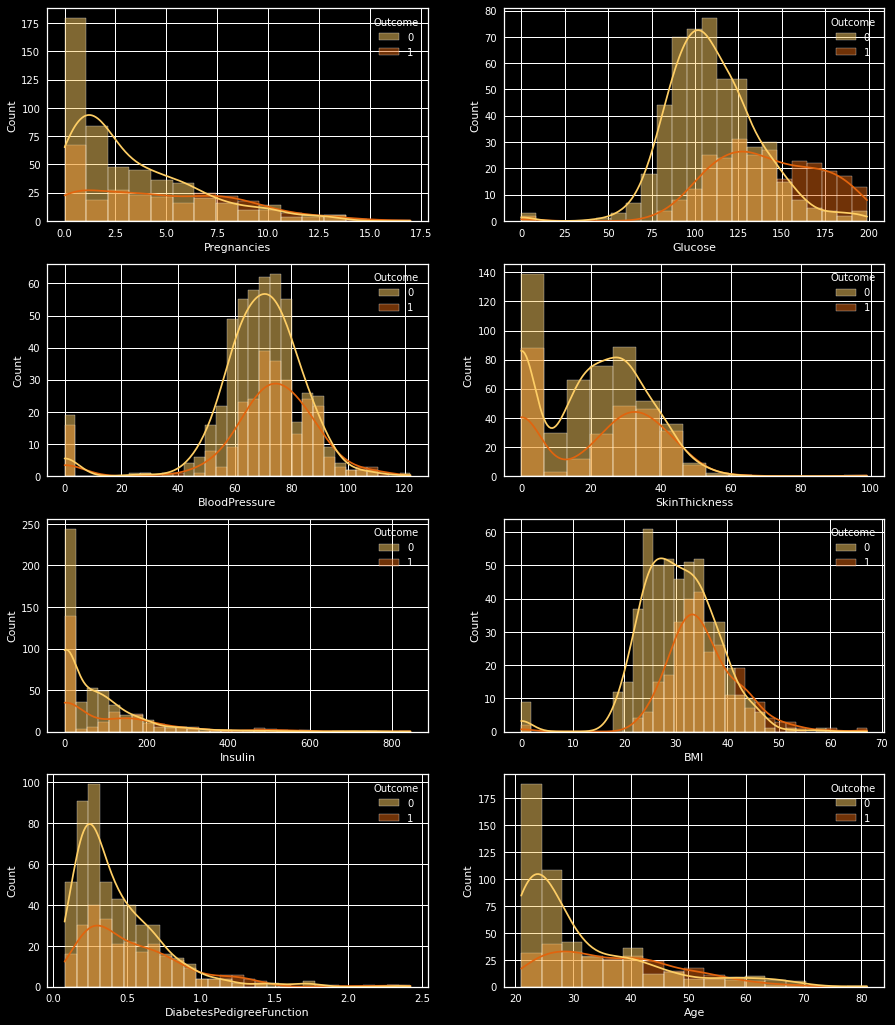

In [7]:
fig,axs = plt.subplots(4,2, figsize = (15,18))

color = 'YlOrBr'

sns.histplot(data=df, x="Pregnancies", kde=True, ax=axs[0, 0], palette=color, hue='Outcome')
sns.histplot(data=df, x="Glucose", kde=True, palette=color, ax=axs[0, 1], hue='Outcome')
sns.histplot(data=df, x="BloodPressure", kde=True, palette=color, ax=axs[1, 0], hue='Outcome')
sns.histplot(data=df, x="SkinThickness", kde=True, palette=color, ax=axs[1, 1], hue='Outcome')
sns.histplot(data=df, x="Insulin", kde=True, palette=color, ax=axs[2, 0], hue='Outcome')
sns.histplot(data=df, x="BMI", kde=True, palette=color, ax=axs[2, 1], hue='Outcome')
sns.histplot(data=df, x="DiabetesPedigreeFunction", kde=True, palette=color, ax=axs[3, 0], hue='Outcome')
sns.histplot(data=df, x="Age", kde=True, palette=color, ax=axs[3, 1], hue='Outcome')

As we can see some data has a large amount of null data, let's check it.

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We can see that we have null minimum values in several features where it has not meaning, for example, null values of the skin thickness are impossible, since this would tell us that said skin does not exist. To the other hand, the blood pressure can't have null values, since this would tell us that this person would be dead. We can say something similar for glucose, insulin and IBM features.

#### Null Data Impact:

In [9]:
caracteristicas_nulas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for caracteristica in caracteristicas_nulas:
    cantidad_nulas = df[df[caracteristica] == 0][caracteristica].count()
    print(f'{caracteristica} presenta {cantidad_nulas} casos nulos: Representan el {round(cantidad_nulas*100/df["Outcome"].count(), 2)}% del dataset')

Glucose presenta 5 casos nulos: Representan el 0.65% del dataset
BloodPressure presenta 35 casos nulos: Representan el 4.56% del dataset
SkinThickness presenta 227 casos nulos: Representan el 29.56% del dataset
Insulin presenta 374 casos nulos: Representan el 48.7% del dataset
BMI presenta 11 casos nulos: Representan el 1.43% del dataset


We can see that the three features with the highest numbers of null values are insulin, skin thickness and blood pressure. A good technique to solve this problem is to assign the mean value of the dataset to this null values.

In [10]:
df_nn = df.copy()
df_nn[caracteristicas_nulas] = df_nn[caracteristicas_nulas].replace(0, df_nn[caracteristicas_nulas].mean())
df_nn.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<AxesSubplot:xlabel='Age', ylabel='Count'>

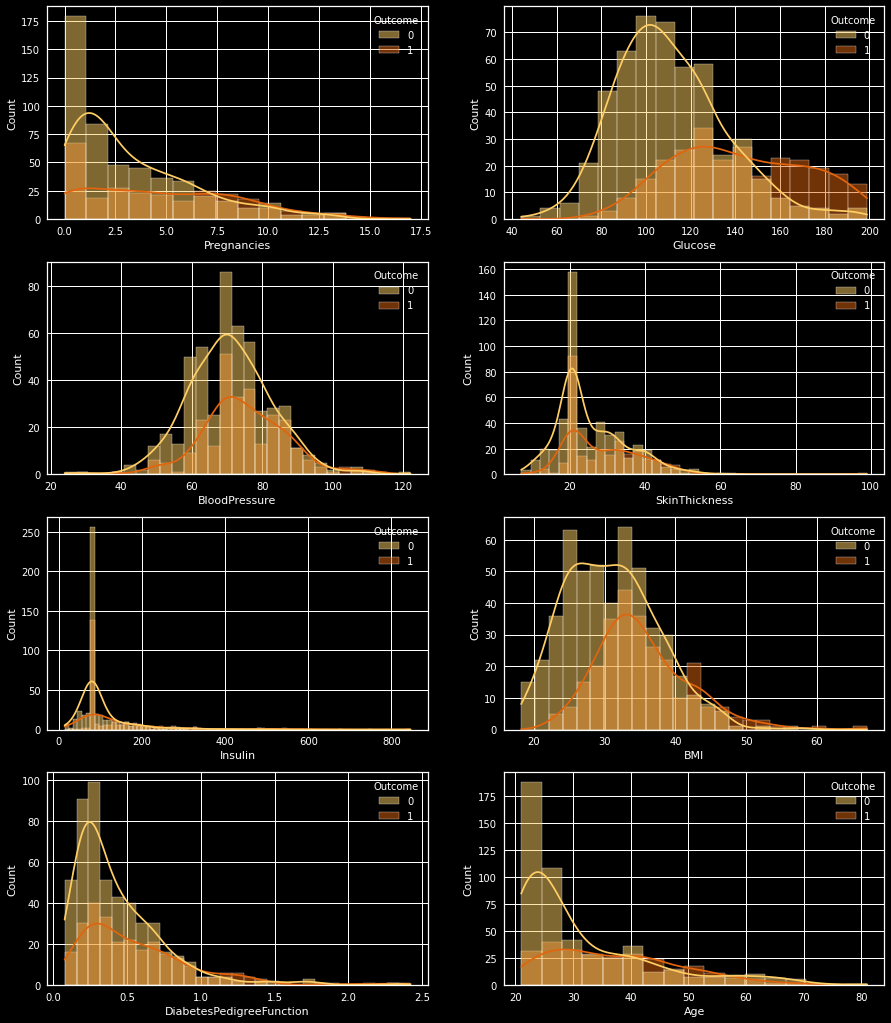

In [11]:
fig,axs = plt.subplots(4,2, figsize = (15,18))

sns.histplot(data=df_nn, x="Pregnancies", kde=True, ax=axs[0, 0], palette=color, hue='Outcome')
sns.histplot(data=df_nn, x="Glucose", kde=True, palette=color, ax=axs[0, 1], hue='Outcome')
sns.histplot(data=df_nn, x="BloodPressure", kde=True, palette=color, ax=axs[1, 0], hue='Outcome')
sns.histplot(data=df_nn, x="SkinThickness", kde=True, palette=color, ax=axs[1, 1], hue='Outcome')
sns.histplot(data=df_nn, x="Insulin", kde=True, palette=color, ax=axs[2, 0], hue='Outcome')
sns.histplot(data=df_nn, x="BMI", kde=True, palette=color, ax=axs[2, 1], hue='Outcome')
sns.histplot(data=df_nn, x="DiabetesPedigreeFunction", kde=True, palette=color, ax=axs[3, 0], hue='Outcome')
sns.histplot(data=df_nn, x="Age", kde=True, palette=color, ax=axs[3, 1], hue='Outcome')

### Finding strong correlations:

<Figure size 2160x2160 with 0 Axes>

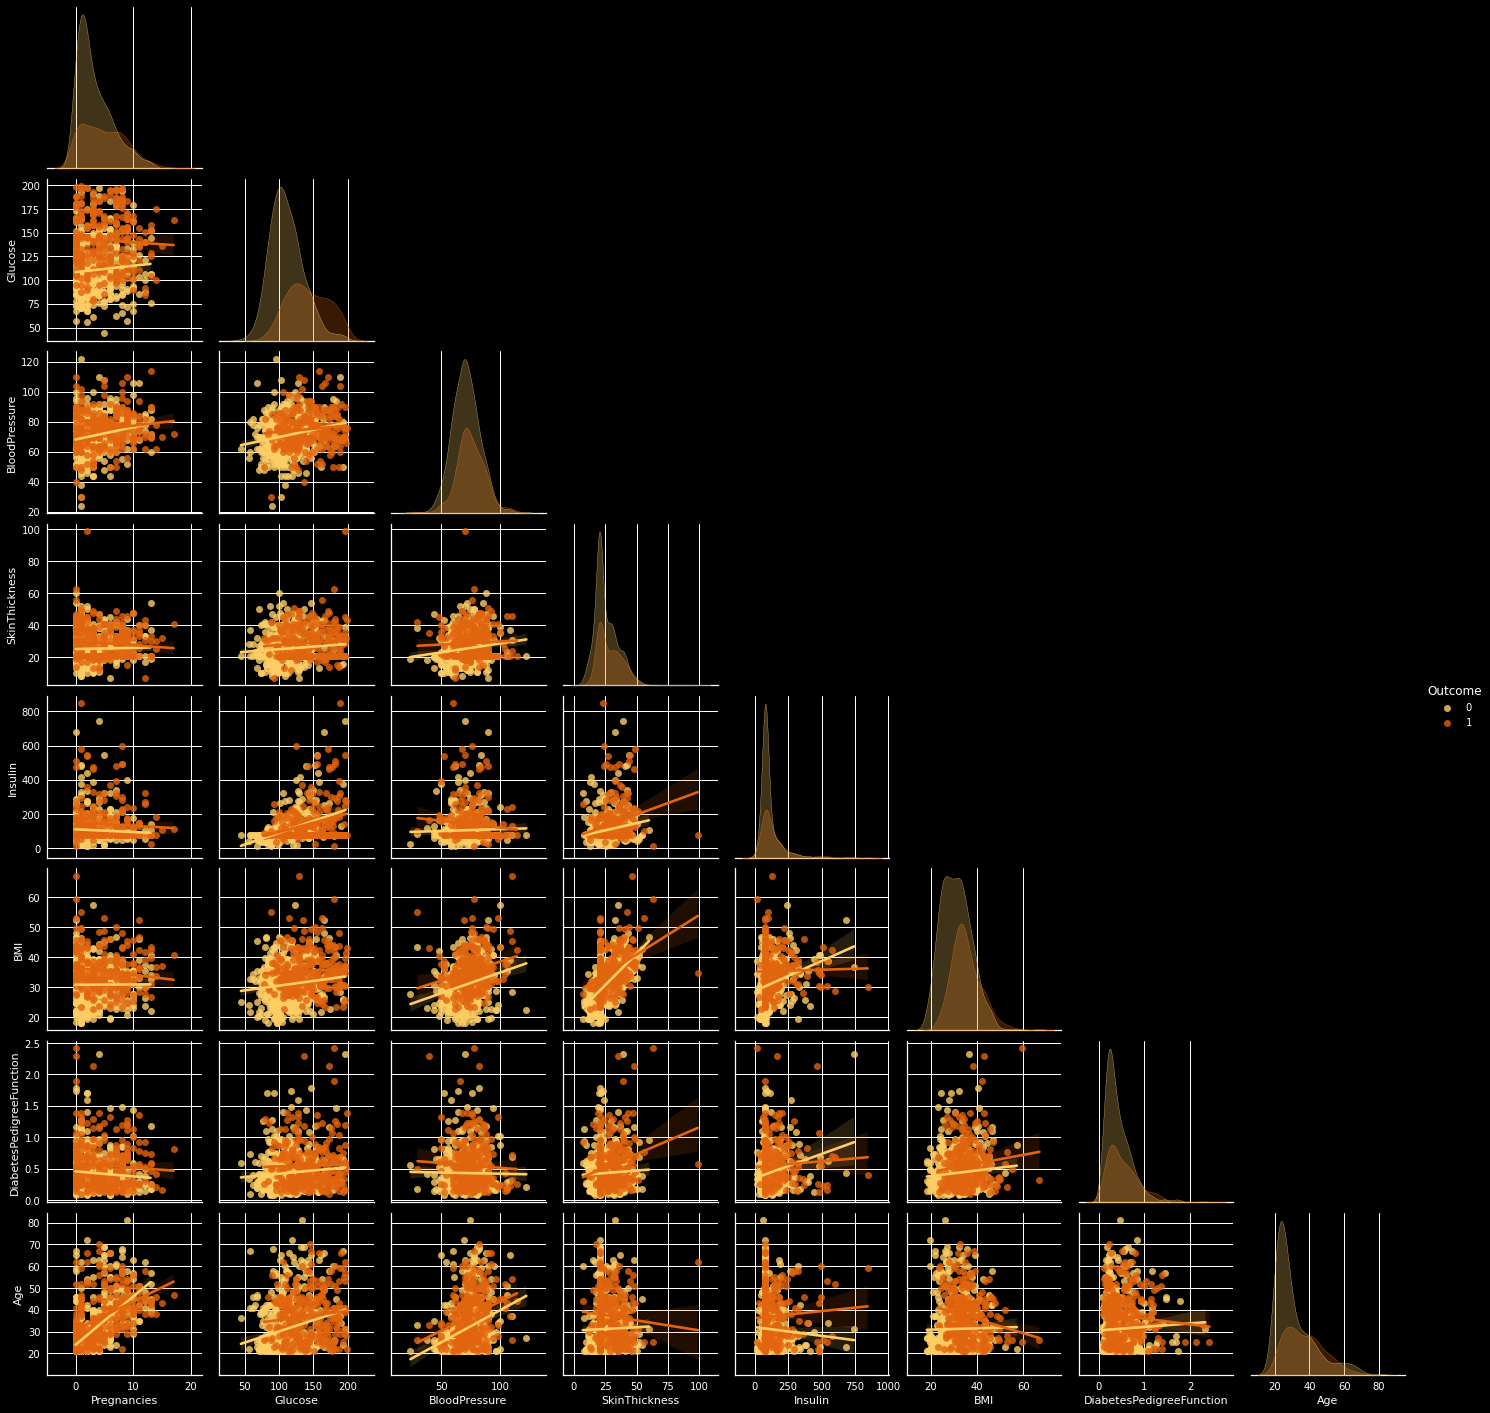

In [12]:
plt.figure(figsize = (30,30))
sns.reset_orig()
plt.style.use("dark_background")

sns.pairplot(df_nn, kind = 'reg',corner = True, palette=color, hue='Outcome')

In [13]:
df_nn.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.127964,0.208984,0.013376,-0.018082,0.021546,-0.033523,0.544341,0.221898
Glucose,0.127964,1.000000,0.219666,0.160766,0.396597,0.231478,0.137106,0.266600,0.492908
BloodPressure,0.208984,0.219666,1.000000,0.134155,0.010926,0.281231,0.000371,0.326740,0.162986
SkinThickness,0.013376,0.160766,0.134155,1.000000,0.240361,0.535703,0.154961,0.026423,0.175026
Insulin,-0.018082,0.396597,0.010926,0.240361,1.000000,0.189856,0.157806,0.038652,0.179185
BMI,0.021546,0.231478,0.281231,0.535703,0.189856,1.000000,0.153508,0.025748,0.312254
DiabetesPedigreeFunction,-0.033523,0.137106,0.000371,0.154961,0.157806,0.153508,1.000000,0.033561,0.173844
Age,0.544341,0.266600,0.326740,0.026423,0.038652,0.025748,0.033561,1.000000,0.238356
Outcome,0.221898,0.492908,0.162986,0.175026,0.179185,0.312254,0.173844,0.238356,1.000000


We can find the features most correlate:

In [14]:
df_corr = df_nn.corr()
df_corr[df_corr == 1] = np.nan
df_corr_u = df_corr.unstack().dropna().drop_duplicates().sort_values(ascending=False)
print(df_corr_u[df_corr_u > 0.25])

Pregnancies    Age        0.544341
SkinThickness  BMI        0.535703
Glucose        Outcome    0.492908
               Insulin    0.396597
BloodPressure  Age        0.326740
BMI            Outcome    0.312254
BloodPressure  BMI        0.281231
Glucose        Age        0.266600
dtype: float64


Important observations:

+ The features most correlate with the outcome are the glucose and IBM features, these features will be important for the prediction.
+ We can see that the numbers of pregnancies, age, glucose and IBM are important factors for building our model.
+ We see that the correlations between age and numbers of pregnancies and between IBM and skin thickness are the highest, these correlations can contribute with multicollinearity problems, i.e., these features could undermine the statistics significance of the independent variables.

----
----
## Dataset split

----
### Training set, test set and validation set:

In [15]:
train_set, test_set = train_test_split(df_nn, test_size=0.5, random_state=42, shuffle=False)
val_set, test_set =  train_test_split(test_set, test_size=0.5, random_state=42, shuffle=False)

----
### Dimension reduction:

In [16]:
X_train = train_set.drop(['Outcome'], axis=1)
y_train = train_set['Outcome'].copy()

X_val = val_set.drop(['Outcome'], axis=1)
y_val = val_set['Outcome'].copy()

X_test = test_set.drop(['Outcome'], axis=1)
y_test = test_set['Outcome'].copy()

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 0 to 383
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               384 non-null    int64  
 1   Glucose                   384 non-null    float64
 2   BloodPressure             384 non-null    float64
 3   SkinThickness             384 non-null    float64
 4   Insulin                   384 non-null    float64
 5   BMI                       384 non-null    float64
 6   DiabetesPedigreeFunction  384 non-null    float64
 7   Age                       384 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 27.0 KB


In [17]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 384 to 575
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               192 non-null    int64  
 1   Glucose                   192 non-null    float64
 2   BloodPressure             192 non-null    float64
 3   SkinThickness             192 non-null    float64
 4   Insulin                   192 non-null    float64
 5   BMI                       192 non-null    float64
 6   DiabetesPedigreeFunction  192 non-null    float64
 7   Age                       192 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 13.5 KB


In [18]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 576 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               192 non-null    int64  
 1   Glucose                   192 non-null    float64
 2   BloodPressure             192 non-null    float64
 3   SkinThickness             192 non-null    float64
 4   Insulin                   192 non-null    float64
 5   BMI                       192 non-null    float64
 6   DiabetesPedigreeFunction  192 non-null    float64
 7   Age                       192 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 13.5 KB


In [19]:
y_train.head(10)

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

----
----
## Data scaling:

In [20]:
rbst_scaler = RobustScaler()
transformer = rbst_scaler.fit(X_train)

In [21]:
dataTrain_prep = transformer.transform(X_train)
X_train_prep = pd.DataFrame(dataTrain_prep, columns=X_train.columns, index=X_train.index)

dataVal_prep = transformer.transform(X_val)
X_val_prep = pd.DataFrame(dataVal_prep, columns=X_val.columns, index=X_val.index)

dataTest_prep = transformer.transform(X_test)
X_test_prep = pd.DataFrame(dataTest_prep, columns=X_test.columns, index=X_test.index)

X_train_prep.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.733728,0.000000,1.109827,0.000000,0.155125,0.631778,1.3125
1,-0.4,-0.757396,-0.375000,0.597599,0.000000,-0.620499,-0.064313,0.1250
2,1.0,1.562130,-0.500000,-0.124944,0.000000,-0.986150,0.745271,0.1875
3,-0.4,-0.662722,-0.375000,0.085371,0.293093,-0.454294,-0.528373,-0.5000
4,-0.6,0.473373,-2.000000,1.109827,1.820425,1.207756,4.820933,0.2500
5,0.4,-0.023669,0.125000,-0.124944,0.000000,-0.731302,-0.442623,0.0625
6,0.0,-0.923077,-1.375000,0.853713,0.169256,-0.132964,-0.324086,-0.1875
7,1.4,-0.047337,-0.180908,-0.124944,0.000000,0.343490,-0.611602,0.0000
8,-0.2,1.893491,-0.125000,1.963539,9.560279,-0.188366,-0.551072,1.5000
9,1.0,0.189349,1.500000,-0.124944,0.000000,-0.022983,-0.364439,1.5625


----
----
# Training of machine learning models

## Individual learners:

----
### Logistic Regression:

In [22]:
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_prep, y_train)

LogisticRegression(max_iter=5000)

In [23]:
y_val_pred_rl = clf.predict(X_val_prep)

In [24]:
print("Precision:", precision_score(y_val, y_val_pred_rl, pos_label=1))
print("Recall:", recall_score(y_val, y_val_pred_rl, pos_label=1))
print("F1 score:", f1_score(y_val, y_val_pred_rl, pos_label=1))
print("Accuracy:", accuracy_score(y_val, y_val_pred_rl))

Precision: 0.6888888888888889
Recall: 0.5849056603773585
F1 score: 0.6326530612244898
Accuracy: 0.8125


In [25]:
y_test_pred_rl = clf.predict(X_test_prep)

In [26]:
print("Precision:", precision_score(y_test, y_test_pred_rl, pos_label=1))
print("Recall:", recall_score(y_test, y_test_pred_rl, pos_label=1))
print("F1 score:", f1_score(y_test, y_test_pred_rl, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_test_pred_rl))

Precision: 0.7719298245614035
Recall: 0.6285714285714286
F1 score: 0.6929133858267716
Accuracy: 0.796875


----
### SVM (Vector Support Machines)

In [27]:
svm_clf = SVC(kernel='rbf', gamma=0.1, C=50)
svm_clf.fit(X_train_prep, y_train)

SVC(C=50, gamma=0.1)

In [28]:
y_val_pred_svm = svm_clf.predict(X_val_prep)

In [29]:
print("Precision:", precision_score(y_val, y_val_pred_svm, pos_label=1))
print("Recall:", recall_score(y_val, y_val_pred_svm, pos_label=1))
print("F1 score:", f1_score(y_val, y_val_pred_svm, pos_label=1))
print("Accuracy:", accuracy_score(y_val, y_val_pred_svm))

Precision: 0.6222222222222222
Recall: 0.5283018867924528
F1 score: 0.5714285714285715
Accuracy: 0.78125


In [30]:
y_test_pred_svm = svm_clf.predict(X_test_prep)

In [31]:
print("Precision:", precision_score(y_test, y_test_pred_svm, pos_label=1))
print("Recall:", recall_score(y_test, y_test_pred_svm, pos_label=1))
print("F1 score:", f1_score(y_test, y_test_pred_svm, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_test_pred_svm))

Precision: 0.71875
Recall: 0.6571428571428571
F1 score: 0.6865671641791045
Accuracy: 0.78125


----
### Decision Tree:
The use of this classification model with scaled datasets, in general, leads to a poor performance in the final prediction of the model, for this reason we will use the sets without previous scaling.

In [32]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [33]:
y_val_pred_dt = dt_clf.predict(X_val)

In [34]:
print("Precision:", precision_score(y_val, y_val_pred_dt, pos_label=1))
print("Recall:", recall_score(y_val, y_val_pred_dt, pos_label=1))
print("F1 score:", f1_score(y_val, y_val_pred_dt, pos_label=1))
print("Accuracy:", accuracy_score(y_val, y_val_pred_dt))

Precision: 0.45
Recall: 0.5094339622641509
F1 score: 0.47787610619469023
Accuracy: 0.6927083333333334


In [35]:
y_test_pred_dt = dt_clf.predict(X_test)

In [36]:
print("Precision:", precision_score(y_test, y_test_pred_dt, pos_label=1))
print("Recall:", recall_score(y_test, y_test_pred_dt, pos_label=1))
print("F1 score:", f1_score(y_test, y_test_pred_dt, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_test_pred_dt))

Precision: 0.6617647058823529
Recall: 0.6428571428571429
F1 score: 0.6521739130434783
Accuracy: 0.75


-----
-----
## Ensemble Learning:
This technique consist of making use of several algorithms of machine learning to obtain an ensemble predictions that is relatively better than the predictions of individual learners.

-----
### Bagging with Random Forest:
Bagging is a technique that consist of combining several equal machine learning models where each model uses different subsets of the training set, in this way we compensate the error in the prediccion between models, obtaining a final model that has an output with less variance in comparison with the output of the individual models.

The Random Forest algorithm is an ensemble implemented with Baggin, where hundreds of decision trees are used to determinate the output of the final model.

In [37]:
rf_clf = RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=42)

In [38]:
y_val_pred_rf = rf_clf.predict(X_val)
print("Precision:", precision_score(y_val, y_val_pred_rf, pos_label=1))
print("Recall:", recall_score(y_val, y_val_pred_rf, pos_label=1))
print("F1 score:", f1_score(y_val, y_val_pred_rf, pos_label=1))
print("Accuracy:", accuracy_score(y_val, y_val_pred_rf))

Precision: 0.6530612244897959
Recall: 0.6037735849056604
F1 score: 0.6274509803921567
Accuracy: 0.8020833333333334


----- 
### Voting with PyCaret: Hard Voting and Soft Voting

Voting is a technique that consist of training several machines learning models with the same dataset, where each model will cast a 'vote' which is nothing more than the result of its own prediction, this way, the final predictions are definite of majority vote.
Inside these techniques exists two branches, Hard Voting define the final prediction with the label that obtain most votes in comparison with Soft Voting define the final prediction with the label that obtain major sum of the probabilities.

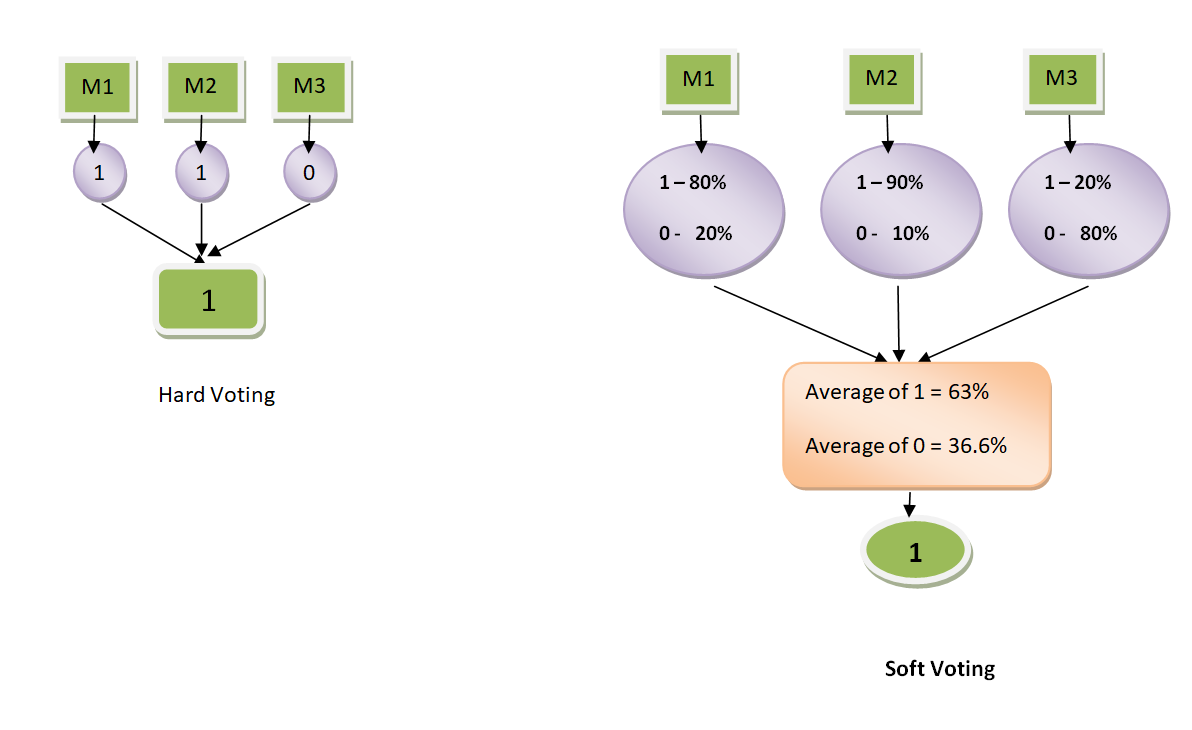

In [68]:
Image("../input/imagenes/sources/voting.png")

First, I will compare several models for determinate the tops models that get better results.

In [52]:
clf1 = setup(data = df_nn, train_size=0.75, target = 'Outcome', preprocess = False, silent = True)

,Description,Value
0,session_id,1685
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Transformed Train Set,"(576, 8)"
9,Transformed Test Set,"(192, 8)"


In [53]:
best = compare_models(sort='F1', n_select = 5, exclude=['dummy','svm','ridge','knn','dt','nb','qda', 'lr'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7812,0.8278,0.6282,0.7101,0.6627,0.5023,0.5073,0.4700
catboost,CatBoost Classifier,0.7812,0.8412,0.6179,0.7140,0.6565,0.4984,0.5054,1.8770
gbc,Gradient Boosting Classifier,0.7780,0.8302,0.6192,0.7068,0.6538,0.4925,0.4993,0.0970
et,Extra Trees Classifier,0.7829,0.8260,0.6071,0.7127,0.6532,0.4974,0.5024,0.4670
ada,Ada Boost Classifier,0.7709,0.8204,0.6134,0.6940,0.6445,0.4781,0.4844,0.0960
lda,Linear Discriminant Analysis,0.7761,0.8337,0.5621,0.7176,0.6267,0.4717,0.4808,0.0120


Because some estimators can't be analyzed with some tools that we will use, we exclude several them.

In [58]:
tuned_models = [tune_model(i, tuner_verbose = False) for i in best]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7931,0.9184,0.5500,0.7857,0.6471,0.5071,0.5232
1,0.8276,0.9132,0.6000,0.8571,0.7059,0.5892,0.6080
2,0.7414,0.8224,0.4000,0.7273,0.5161,0.3594,0.3893
3,0.6552,0.7316,0.4000,0.5000,0.4444,0.1989,0.2015
4,0.7931,0.8572,0.5500,0.7857,0.6471,0.5071,0.5232
5,0.7414,0.8079,0.3500,0.7778,0.4828,0.3419,0.3904
6,0.7719,0.8608,0.4737,0.7500,0.5806,0.4348,0.4564
7,0.8070,0.8566,0.5263,0.8333,0.6452,0.5217,0.5477
8,0.7719,0.7978,0.5789,0.6875,0.6286,0.4658,0.4693


#### Soft Voting:

In [65]:
blend_soft = blend_models(estimator_list = tuned_models, optimize = 'F1', method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8276,0.9171,0.6500,0.8125,0.7222,0.5994,0.6073
1,0.8793,0.8987,0.8500,0.8095,0.8293,0.7360,0.7365
2,0.7931,0.8447,0.6000,0.7500,0.6667,0.5193,0.5261
3,0.7241,0.7303,0.7500,0.5769,0.6522,0.4300,0.4401
4,0.7586,0.8447,0.6000,0.6667,0.6316,0.4528,0.4542
5,0.7241,0.7987,0.5000,0.6250,0.5556,0.3591,0.3638
6,0.7895,0.9030,0.5789,0.7333,0.6471,0.5000,0.5071
7,0.7895,0.8629,0.7368,0.6667,0.7000,0.5385,0.5401
8,0.6842,0.7729,0.6842,0.5200,0.5909,0.3415,0.3500


In [70]:
y_test_pred_bs = blend_soft.predict(X_test)

In [71]:
print("Precision:", precision_score(y_test, y_test_pred_bs, pos_label=1))
print("Recall:", recall_score(y_test, y_test_pred_bs, pos_label=1))
print("F1 score:", f1_score(y_test, y_test_pred_bs, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_test_pred_bs))

Precision: 0.8142857142857143
Recall: 0.8142857142857143
F1 score: 0.8142857142857143
Accuracy: 0.8645833333333334


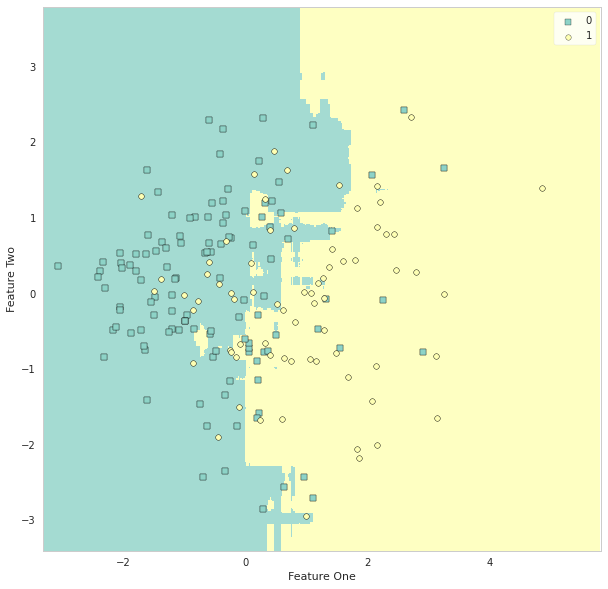

In [96]:
plt.figure(figsize=(10, 10))
plot_model(blend_soft, plot='boundary')

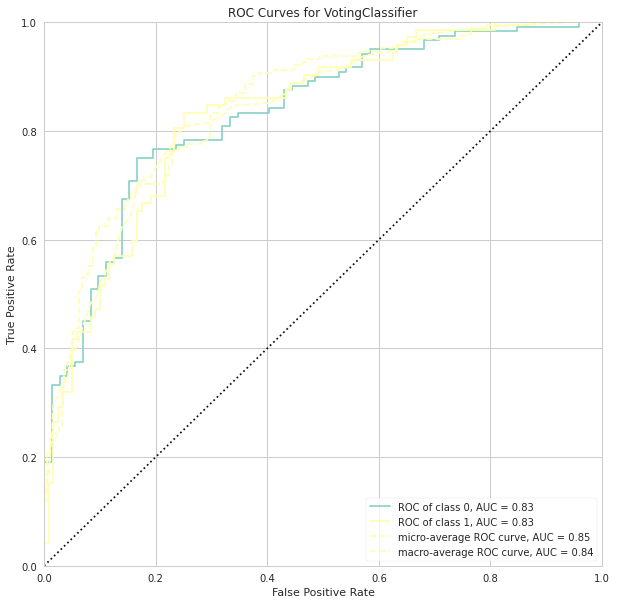

In [99]:
plt.figure(figsize=(10, 10))
plot_model(blend_soft, plot='auc')

Text(0.5, 1.0, 'Confusion Matrix (Voting Hard)')

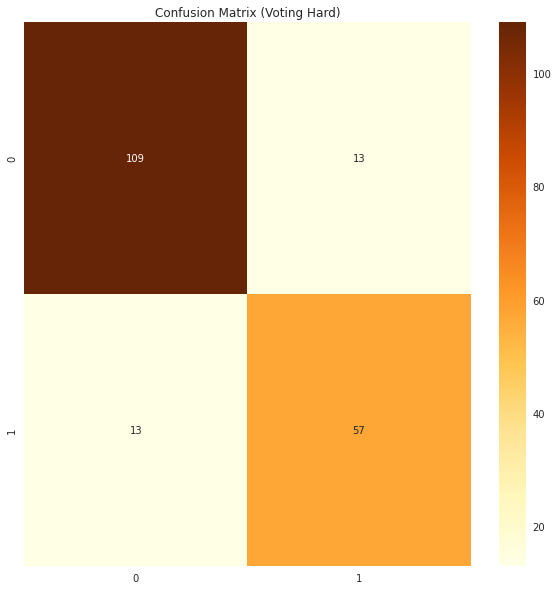

In [97]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred_bs), cmap = color,annot = True, fmt='d')
ax.set_title('Confusion Matrix (Voting Hard)')

#### Hard Voting:

In [76]:
blend_hard = blend_models(estimator_list = tuned_models, optimize = 'F1', method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8103,0.0000,0.6000,0.8000,0.6857,0.5538,0.5656
1,0.8621,0.0000,0.8000,0.8000,0.8000,0.6947,0.6947
2,0.7759,0.0000,0.5500,0.7333,0.6286,0.4727,0.4828
3,0.7586,0.0000,0.7000,0.6364,0.6667,0.4781,0.4795
4,0.7931,0.0000,0.6000,0.7500,0.6667,0.5193,0.5261
5,0.7414,0.0000,0.4500,0.6923,0.5455,0.3759,0.3929
6,0.7895,0.0000,0.5789,0.7333,0.6471,0.5000,0.5071
7,0.8246,0.0000,0.6842,0.7647,0.7222,0.5946,0.5966
8,0.7368,0.0000,0.6842,0.5909,0.6341,0.4304,0.4332


In [77]:
y_test_pred_bh = blend_hard.predict(X_test)

In [78]:
print("Precision:", precision_score(y_test, y_test_pred_bh, pos_label=1))
print("Recall:", recall_score(y_test, y_test_pred_bh, pos_label=1))
print("F1 score:", f1_score(y_test, y_test_pred_bh, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_test_pred_bh))

Precision: 0.7945205479452054
Recall: 0.8285714285714286
F1 score: 0.8111888111888111
Accuracy: 0.859375


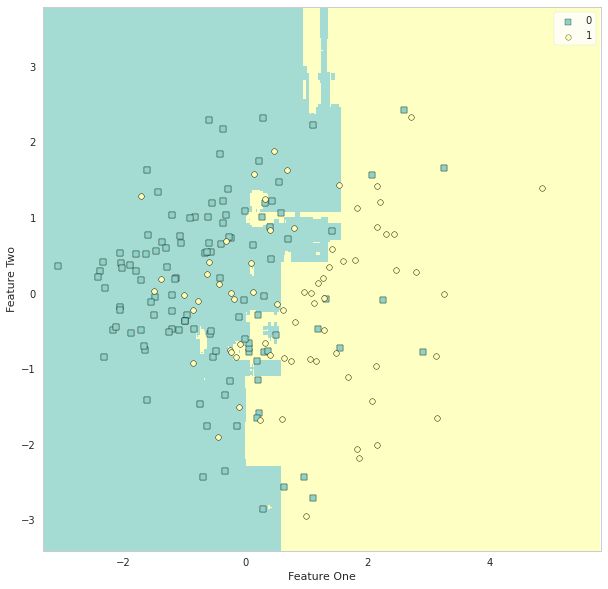

In [98]:
plt.figure(figsize=(10, 10))
plot_model(blend_hard, plot='boundary')

Text(0.5, 1.0, 'Confusion Matrix (Voting Soft)')

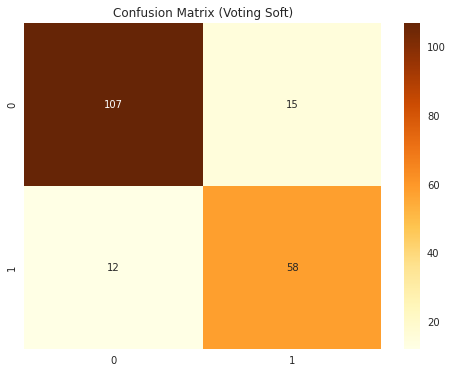

In [80]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred_bh), cmap = color,annot = True, fmt='d')
ax.set_title('Confusion Matrix (Voting Soft)')

-----

### Stacking with PyCaret:

Stacking is a technique that consist exactly in the stacking of several machine learning models, them can be different or no, stacking consist basically of using the output of several models as inputs to several other  models. This stack can be single or multilayers.

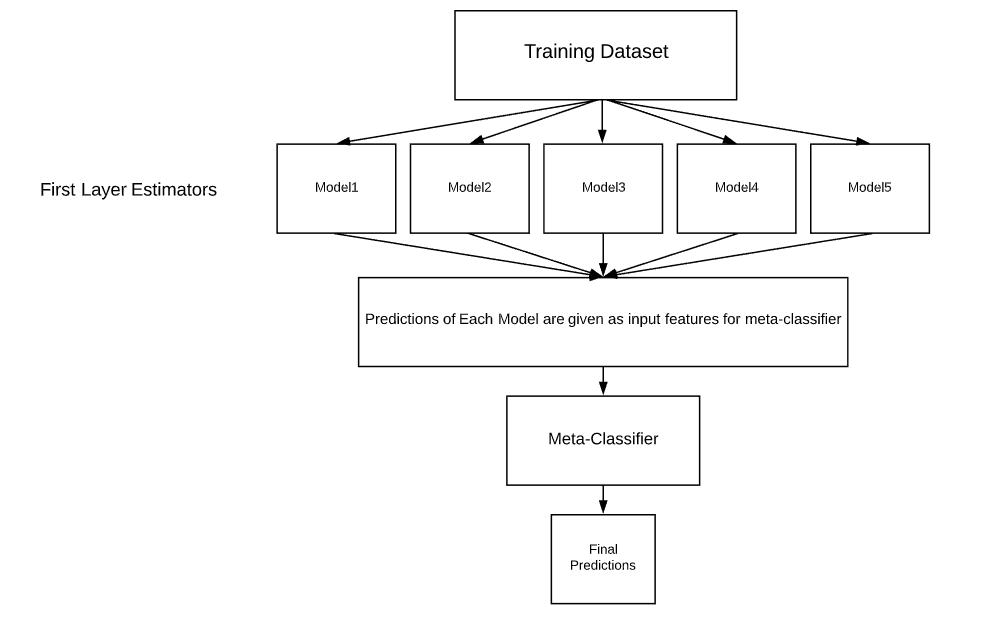

In [69]:
Image("../input/imagenes/sources/stacking.png")

Next I will do an analysis with one of the models that generally gives us the best result, this is the CatBoost Classifier model to later compare results with an Ensemble Learning model.

In [41]:
catboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6552,0.7593,0.5714,0.5217,0.5455,0.2686,0.2693
1,0.7586,0.8687,0.6190,0.6842,0.6500,0.4665,0.4679
2,0.7414,0.8134,0.5238,0.6875,0.5946,0.4098,0.4179
3,0.7759,0.8275,0.4762,0.8333,0.6061,0.4652,0.5008
4,0.8103,0.8662,0.7619,0.7273,0.7442,0.5936,0.5940
5,0.8103,0.8597,0.6667,0.7778,0.7179,0.5764,0.5802
6,0.7544,0.8730,0.5714,0.7059,0.6316,0.4504,0.4561
7,0.7719,0.8267,0.5238,0.7857,0.6286,0.4733,0.4936
8,0.7193,0.7716,0.5500,0.6111,0.5789,0.3693,0.3704


Let's look at the impact of each data feature on the prediction of our models.

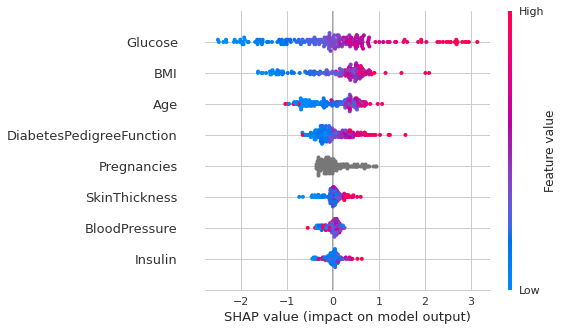

In [107]:
#plt.style.available
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 15))
interpret_model(catboost)

Observations:
+ As we have already said, the characteristic of Glucose is the one that has the greatest impact on the predictions of our models.
+ We can also see that skin thickness, blood pressure and insulin level are the 3 characteristics that generate the least impact on the predictions of our models.

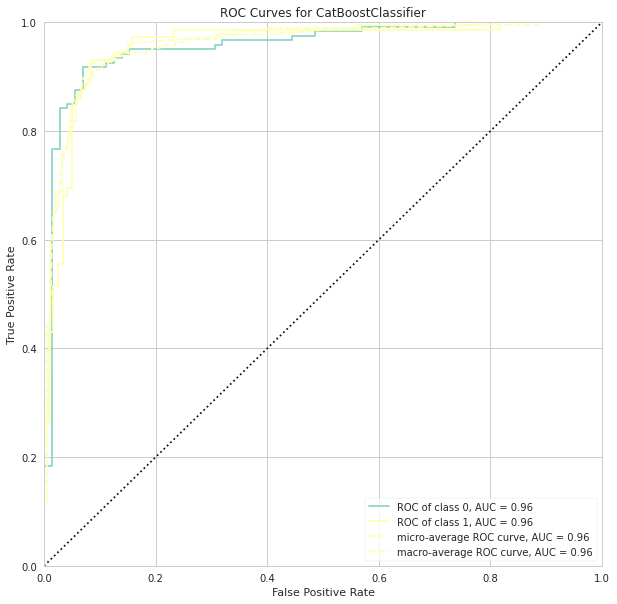

In [108]:
plt.figure(figsize=(10, 10))
plot_model(catboost)

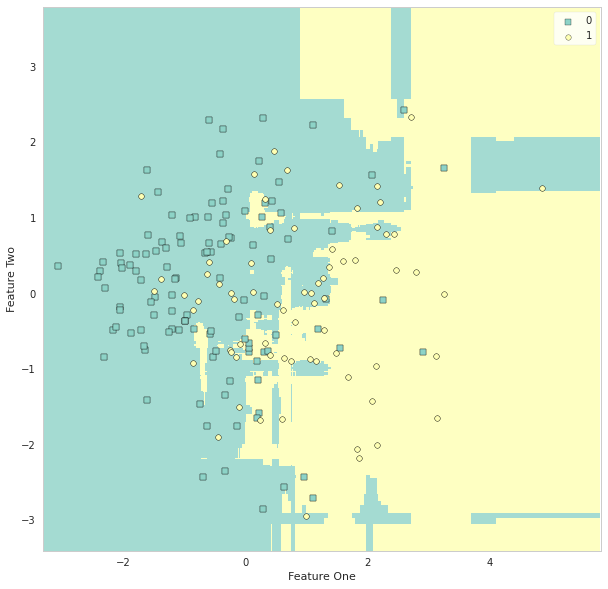

In [109]:
plt.figure(figsize=(10, 10))
plot_model(catboost, plot="boundary")

In [57]:
y_test_pred_cb = catboost.predict(X_test)
print("Precision:", precision_score(y_test, y_test_pred_cb, pos_label=1))
print("Recall:", recall_score(y_test, y_test_pred_cb, pos_label=1))
print("F1 score:", f1_score(y_test, y_test_pred_cb, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_test_pred_cb))

Precision: 0.9090909090909091
Recall: 0.8571428571428571
F1 score: 0.8823529411764706
Accuracy: 0.9166666666666666


Now let's see how to implement the Stacking technique with PyCaret:

In [59]:
stack_model = stack_models(estimator_list = tuned_models, meta_model = best[0], optimize = 'F1', method='predict', restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7931,0.9164,0.5500,0.7857,0.6471,0.5071,0.5232
1,0.8448,0.8836,0.7500,0.7895,0.7692,0.6525,0.6530
2,0.8103,0.8480,0.6500,0.7647,0.7027,0.5648,0.5688
3,0.7069,0.7072,0.6500,0.5652,0.6047,0.3736,0.3759
4,0.7931,0.8171,0.6000,0.7500,0.6667,0.5193,0.5261
5,0.7414,0.7638,0.4000,0.7273,0.5161,0.3594,0.3893
6,0.8070,0.8698,0.6316,0.7500,0.6857,0.5479,0.5522
7,0.8421,0.8726,0.7895,0.7500,0.7692,0.6494,0.6498
8,0.7368,0.7265,0.6316,0.6000,0.6154,0.4156,0.4159


In [60]:
y_test_pred_st = stack_model.predict(X_test)

In [61]:
print("Precision:", precision_score(y_test, y_test_pred_st, pos_label=1))
print("Recall:", recall_score(y_test, y_test_pred_st, pos_label=1))
print("F1 score:", f1_score(y_test, y_test_pred_st, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_test_pred_st))

Precision: 0.8378378378378378
Recall: 0.8857142857142857
F1 score: 0.8611111111111112
Accuracy: 0.8958333333333334


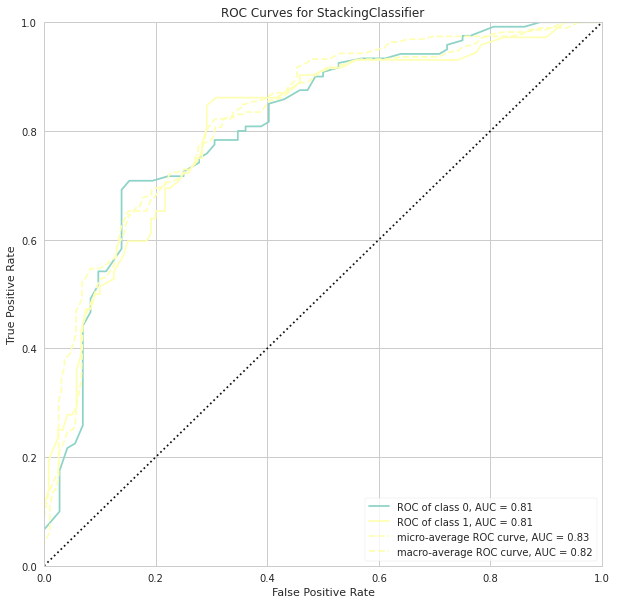

In [110]:
plt.figure(figsize=(10, 10))
plot_model(stack_model, plot="auc")

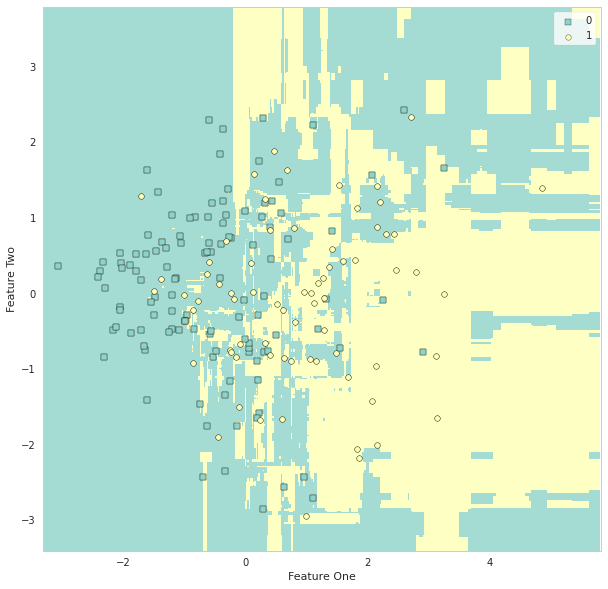

In [111]:
plt.figure(figsize=(10, 10))
plot_model(stack_model, plot="boundary")

Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

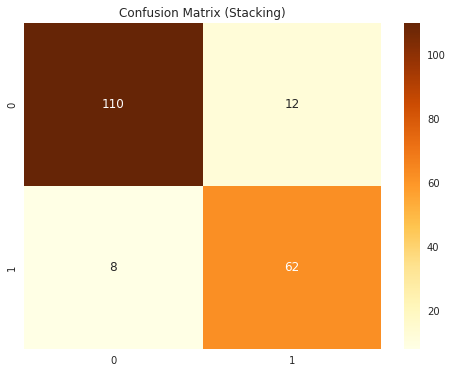

In [64]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred_st), cmap = color,annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

#### Final model calibration
This function calibrates the probability of an estimator by using Logistic or Isotonic Regression.

In [81]:
cali_model = calibrate_model(stack_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7586,0.9079,0.4500,0.7500,0.5625,0.4099,0.4354
1,0.8448,0.8697,0.7500,0.7895,0.7692,0.6525,0.6530
2,0.7931,0.8368,0.5500,0.7857,0.6471,0.5071,0.5232
3,0.6724,0.7105,0.5500,0.5238,0.5366,0.2835,0.2837
4,0.7759,0.7908,0.5500,0.7333,0.6286,0.4727,0.4828
5,0.7586,0.7711,0.4500,0.7500,0.5625,0.4099,0.4354
6,0.8070,0.9086,0.6316,0.7500,0.6857,0.5479,0.5522
7,0.7895,0.8532,0.5789,0.7333,0.6471,0.5000,0.5071
8,0.7193,0.7078,0.5263,0.5882,0.5556,0.3514,0.3525


<Figure size 720x720 with 0 Axes>

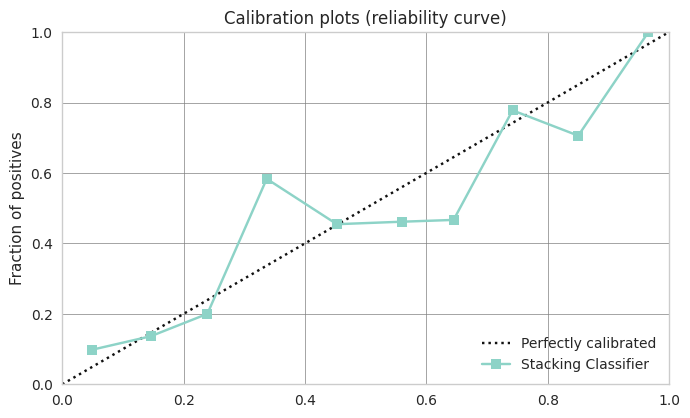

In [112]:
plt.figure(figsize=(10, 10))
plot_model(stack_model, plot='calibration')

<Figure size 720x720 with 0 Axes>

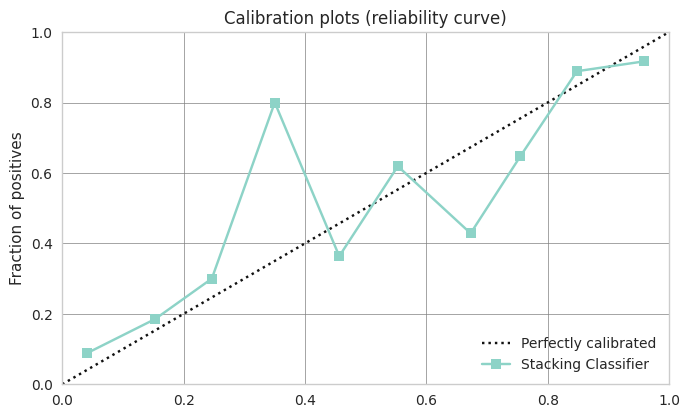

In [113]:
plt.figure(figsize=(10, 10))
plot_model(cali_model, plot='calibration')

In [82]:
final_model = finalize_model(cali_model)

<Figure size 720x720 with 0 Axes>

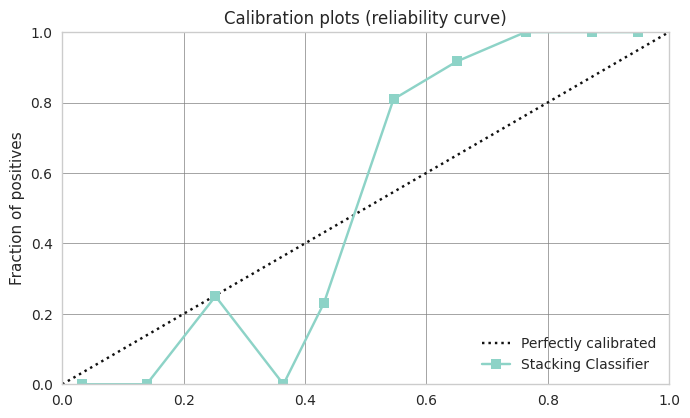

In [114]:
plt.figure(figsize=(10, 10))
plot_model(final_model, plot='calibration')

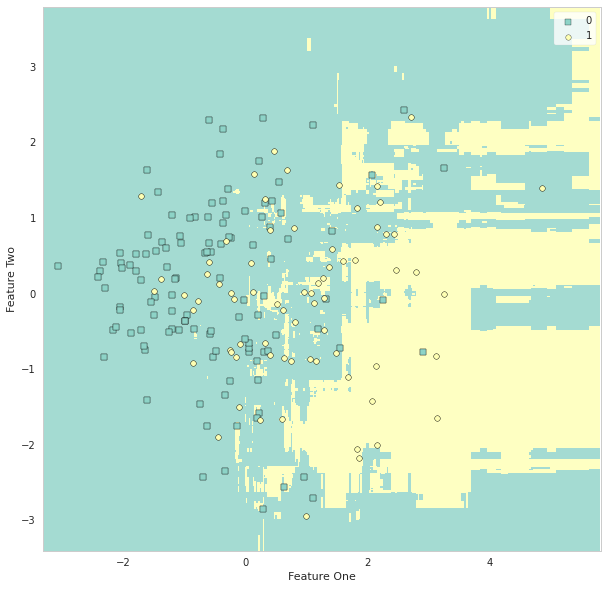

In [116]:
plt.figure(figsize=(10, 10))
plot_model(final_model, plot='boundary')

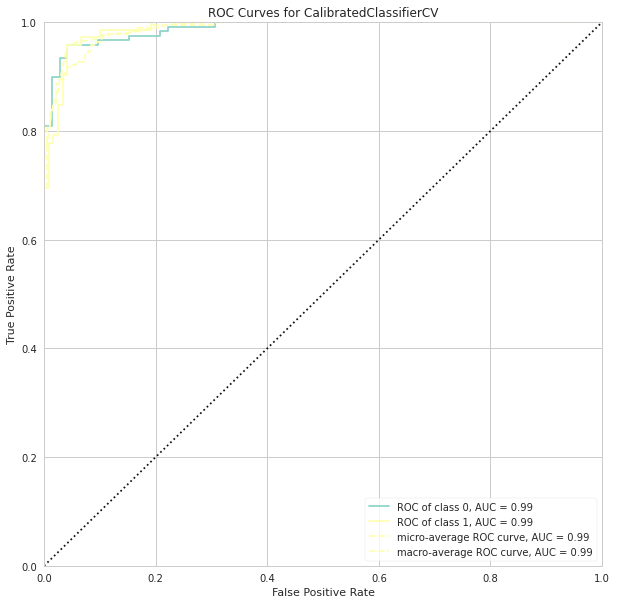

In [117]:
plt.figure(figsize=(10, 10))
plot_model(final_model, plot='auc')

In [84]:
y_test_pred_f = final_model.predict(X_test)

In [85]:
print("Precision:", precision_score(y_test, y_test_pred_f, pos_label=1))
print("Recall:", recall_score(y_test, y_test_pred_f, pos_label=1))
print("F1 score:", f1_score(y_test, y_test_pred_f, pos_label=1))
print("Accuracy:", accuracy_score(y_test, y_test_pred_f))

Precision: 0.9682539682539683
Recall: 0.8714285714285714
F1 score: 0.9172932330827068
Accuracy: 0.9427083333333334


Text(0.5, 1.0, 'Confusion Matrix (Final Stacking)')

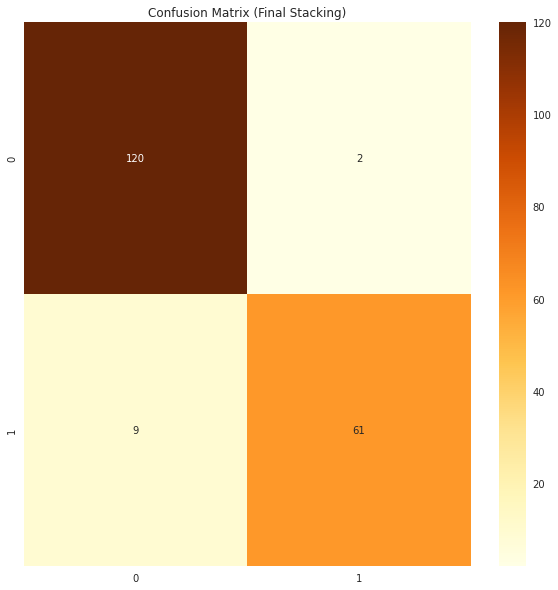

In [118]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred_f), cmap = color,annot = True, fmt='d')
ax.set_title('Confusion Matrix (Final Stacking)')

----
----
# Conclusion:
We can see how an Ensemble Learning model built on the basis of the Stacking technique obtains better results for this problem than if we approached it with individual estimators, it should be noted that the result could improve or worsen by modifying the hyperparameters or simply due to changes in the preprocessing of the dataset, for example, eliminating characteristics that we believe do not influence the prediction when in fact it does.